
# Value Iteration

This file contains the code for control problem. Value Iteration (VI) algorithm is implemented to calculate optimal policy 

    - There are two versions of value iteration algorithms: "value_iteration" and "value_iteration_viz"

        - value_iteration implements value iteration algorithm and it returns optimal utilities for the given MDP

        - value_iteration_viz implements value iteration algorithm; it stores the values at each iteration allowing the visualization and analysis 
        



## MDP.py contains the following:

    - Model for GridMDP  (GridMDP class)

        - Implements the Grid MDP model in AIMA4e Fig. 16.1

    - Functions for

        - Evaluation of utilities of states for a given policy

        - Calculation of Q value of a state-action pair for a given set of utilities
        
        - Extraction of policy for a given set of utilities

## Visualization.py contains the following functions:

    - Function to produce the animation of GridMDP for iterative algorithms with utilities and policies ovelayed on the grid 

    - Function to produce the plot of GridMDP with utilities and policies ovelayed on the grid 
    

In [1]:
# For Google Colab
# Upload the folder containing this file to google drive.
# Make sure that uninformed_informed_search.py is also in the same folder in google drive.
import sys, os

# Checking if the notebook is opened in google colab
#If YES, mount the google drive and change the directory
if 'google.colab' in sys.modules:

    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # change path to the folder
    path = '/content/drive/My Drive/IT5005/MDP'
    print(path)
    #os.chdir changes the current working directory
    os.chdir(path)
    !pwd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.writer'] = 'ffmpeg'
from Visualization import *
from MDP import *


# Grid MDP modelling

GridMDP implements the system described in Section 16.1 of AIMA4e.

class GridMDP:

 - rows = 3
       
       indicate the number of rows of the grid
       
- columns = 4
       
       indicate the number of columns of the grid

- state is defined as (i,j) where i is the column and j is row, with indexing starts from 1.Index of bottom row is 1 and index of left most column is 1.

       Example:  (2,3) indicates the cell in second row and third column

 - terminal_states={(4, 3): 1, (4, 2): -1} 
    
        (4,3) and (4,2) are terminal states. If the agent enters state (4,3), it collects a reward of 1. If the agent enters state (4,2), it collects a reward of -1. 

 - prob_intended = 0.8
    
        prob_intended is the probability of moving in intended direction

 - prob_perpendicular = 0.8
    
        prob_intended is the probability of moving perpendicular to the intended direction

 - default_reward
        
        indicates the reward for entering non-terminal states

- gamma

       indicates the discount

# Verify transition probabilities and rewards

In [3]:
#Define model with default parameters
mdp = GridMDP()
state = (4,3)   #(4,2)
print(f"Transition Probabilities for the state {state}:")
print(mdp.transition_probabilities[state])
print(f"Rewards for the state {state}:")
print(mdp.rewards[state])
state = (3,3)
print(f"Transition Probabilities for the state {state}:")
print(mdp.transition_probabilities[state])
print(f"Rewards for the state {state}:")
print(mdp.rewards[state])


Transition Probabilities for the state (4, 3):
{'U': [((4, 3), 1.0)], 'D': [((4, 3), 1.0)], 'L': [((4, 3), 1.0)], 'R': [((4, 3), 1.0)]}
Rewards for the state (4, 3):
{'U': {(4, 3): 0}, 'D': {(4, 3): 0}, 'L': {(4, 3): 0}, 'R': {(4, 3): 0}}
Transition Probabilities for the state (3, 3):
{'U': [((3, 3), 0.8), ((2, 3), 0.1), ((4, 3), 0.1)], 'D': [((3, 2), 0.8), ((2, 3), 0.1), ((4, 3), 0.1)], 'L': [((2, 3), 0.8), ((3, 3), 0.1), ((3, 2), 0.1)], 'R': [((4, 3), 0.8), ((3, 3), 0.1), ((3, 2), 0.1)]}
Rewards for the state (3, 3):
{'U': {(3, 3): -0.04, (2, 3): -0.04, (4, 3): 1}, 'D': {(3, 2): -0.04, (2, 3): -0.04, (4, 3): 1}, 'L': {(2, 3): -0.04, (3, 3): -0.04, (3, 2): -0.04}, 'R': {(4, 3): 1, (3, 3): -0.04, (3, 2): -0.04}}


# Value Iteration algorithm

Reference: Figure 16.6 of AIMA4e 

_____________________________________________________________________________________________________________________________________________

Initialize the utility vectors $U$ and $U'$ with zeros    ($U$ is the U_old and $U'$ is U )

Initialize $\delta$ with zero (indicates maximum relative change in utility values)

Repeat the following:

   - $U = U'$      
   
   - for each state s:

      - $U'[s] = \max_{a} Q_{-}Value(mdp,s,a,U)$          

      - if $|U'[s]-U[s]| > \delta $   then $\delta = |U'[s]-U[s]|$

Until $\delta \leq \epsilon \frac{1-\gamma}{\gamma}$

return $U$
_____________________________________________________________________________________________________________________________________________


## Q-value Calculation:

This function calculates state-action value $Q(s,a)$ 
 - $Q_{-}Value(mdp,s,a,U)$ in the above algorithm

The Q-value is calculated as:

$$ Q(s, a) = \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma \cdot U[s'] \right] $$

The above equation is also known as Bellman equation.

It takes three parameters in addition to MDP model ($mdp$): state ($s$), action ($a$), utility of states ($U(s)$)


## Policy Extraction

Value Iteration algorithm provides optimal utilities. extract_policy function extracts optimal policy from these optimal utilities

This function calculates $Q(s,a)$ for each state-action pair and selects the policy as $$\pi(s) = \arg \max_{a} Q(s,a),$$  where
$$ Q(s, a) = \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma \cdot U[s'] \right] $$

Note: If optimal utility values are provided as inputs, this function extracts optimal policy from the optimal utilities

In [4]:
def value_iteration(mdp, epsilon=0.0001):
    # This function returns optimal utilities of mdp
    # It uses iterative method to solve a set of nonlinear (piecewise linear) equations
    
    #Initialize utilities with zeros for all states
    U = {state: 0 for state in mdp.states}
    U_old = {state: 0 for state in mdp.states}
    while True:        
        U_old = U.copy()
        #delta indicates the maximum change of utilities
        delta = 0
        for state in mdp.states:
            #utilities of terminal states are zero 
            if state in mdp.terminal_states:
                continue                
            max_value = float('-inf')
            #Bellman update equation for utilities            
            #Calculate Q(s,a) and utility of state s is the max Q(s,a)
            for action in mdp.actions:
                q_value = calculate_q_value(mdp, state, action, U_old)
                if q_value > max_value:            
                    max_value = q_value
            #Utility is the max Q(s,a)
            U[state] = max_value
            #Finding maximum relative change of utilities
            delta = max(delta, abs(U_old[state] - U[state]))

        if delta <= epsilon*(1-mdp.gamma)/mdp.gamma:
            break

    return U

{(1, 1): 'U', (2, 1): 'L', (3, 1): 'L', (4, 1): 'L', (1, 2): 'U', (3, 2): 'U', (1, 3): 'R', (2, 3): 'R', (3, 3): 'R'}


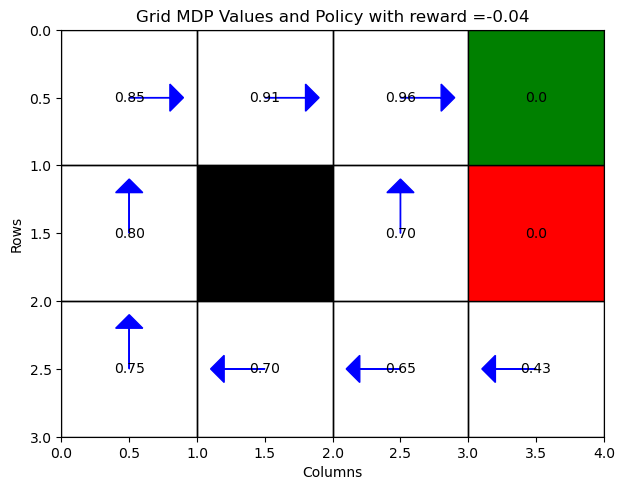

In [5]:
# Example usage of value iteration
mdp = GridMDP(gamma = 1,default_reward=-0.04)
# Perform value iteration to find the optimal utilities
optimal_utilities = value_iteration(mdp)
#Extract optimal policy from optimal utilities
optimal_policy = extract_policy(mdp, optimal_utilities)
print(optimal_policy)
plot_policy_with_utilities(mdp, optimal_utilities, optimal_policy)

In [6]:
def value_iteration_viz(mdp, epsilon=0.0001):
    # This function returns optimal utilities of mdp
    # It uses iterative method to solve a set of nonlinear (piecewise linear) equations


    #Initialize Values (utilities) with zeros for all states
    U = {state: 0 for state in mdp.states}
    U_old = {state: 0 for state in mdp.states}
    all_U = []  # List to store values at each iteration (for visualization)
    all_policy = []  # List to store policy at each iteration (for visualization)
    iters = 0
    while True:        
        U_old = U.copy()
        #delta indicates the maximum change of utilities
        delta = 0
        for state in mdp.states:
            #utilities of terminal states are fixed 
            if state in mdp.terminal_states:
                continue                
            max_value = float('-inf')
            #Bellman update equation for utilities            
            #Calculate Q(s,a) and utility of state s is the max Q(s,a)
            for action in mdp.actions:
                q_value = calculate_q_value(mdp, state, action, U_old)
                if q_value > max_value:            
                    max_value = q_value
            #Utility is the max Q(s,a)
            U[state] = max_value
            #Finding maximum relative change of utilities
            delta = max(delta, abs(U_old[state] - U[state]))
            
        #For visualization
        all_U.append(U.copy())  # Store a copy of the value function at this iteration
        all_policy.append(extract_policy(mdp, U))  # Store a copy of the policy at this iteration
        iters = iters +1
        if delta <= epsilon*(1-mdp.gamma)/mdp.gamma:
            break

    return all_U, all_policy, iters

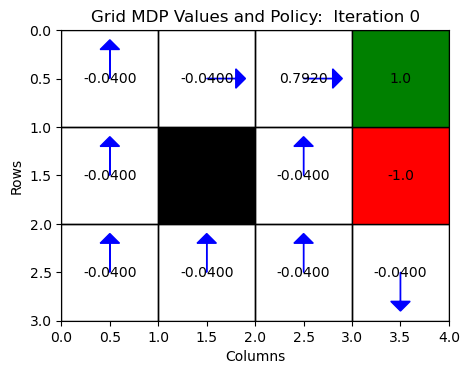

In [7]:
# Example usage of value iteration
mdp = GridMDP(gamma = 1,default_reward=-0.04)
# Perform value iteration to find the optimal value function and policy
all_U, all_policy, iters = value_iteration_viz(mdp,epsilon=0.001)
optimal_policy = all_policy[-1]
optimal_utilities = all_U[-1]
# Create the animation of the value iteration process
ani = animation_policy_with_utilities(mdp, all_U, all_policy, pause_time=2)
# Display the animation as a video
#HTML(ani.to_html5_video())

# Function to plot convergence of states 

This function takes set of states to track and plot the utilities of states across iterations

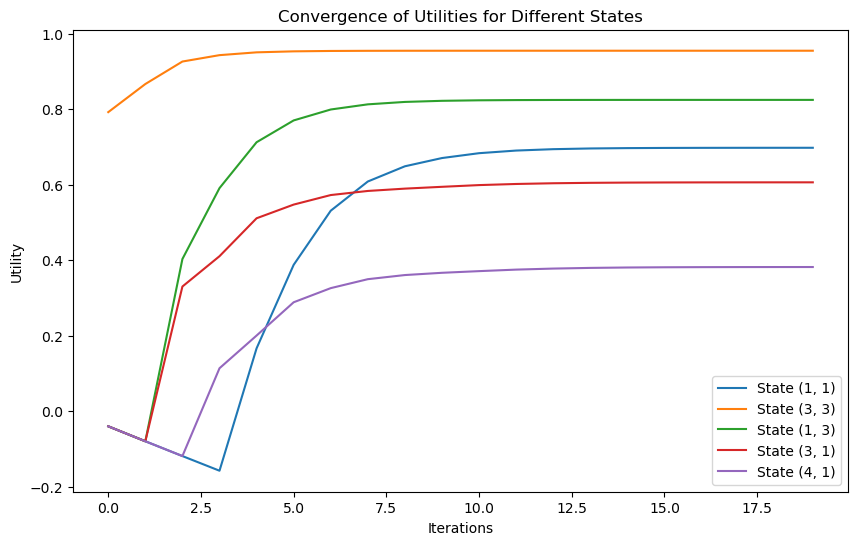

In [8]:
def plot_value_convergence(mdp, states_to_track, epsilon=0.001):
    all_U, all_policy, iter_count = value_iteration_viz(mdp, epsilon)
    iterations = range(iter_count)   #range(len(all_U))
    fig, ax = plt.subplots(figsize=(10, 6))
    for state in states_to_track:
        values = [U[state] for U in all_U]
        ax.plot(iterations, values, label=f'State {state}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Utility')
    ax.set_title('Convergence of Utilities for Different States')
    ax.legend()
    plt.show()


#Example
# Example usage of value iteration
mdp = GridMDP(gamma = 0.99,default_reward=-0.04)
states_to_track = [(1, 1), (3, 3), (1,3), (3,1),(4,1)]  # Specify the states you want to track
plot_value_convergence(mdp, states_to_track, epsilon=0.01)

# Function to plot number of iterations to converge

This function plots the number of iterations required to converge for the utilities across different discount factors  and  epsilon values

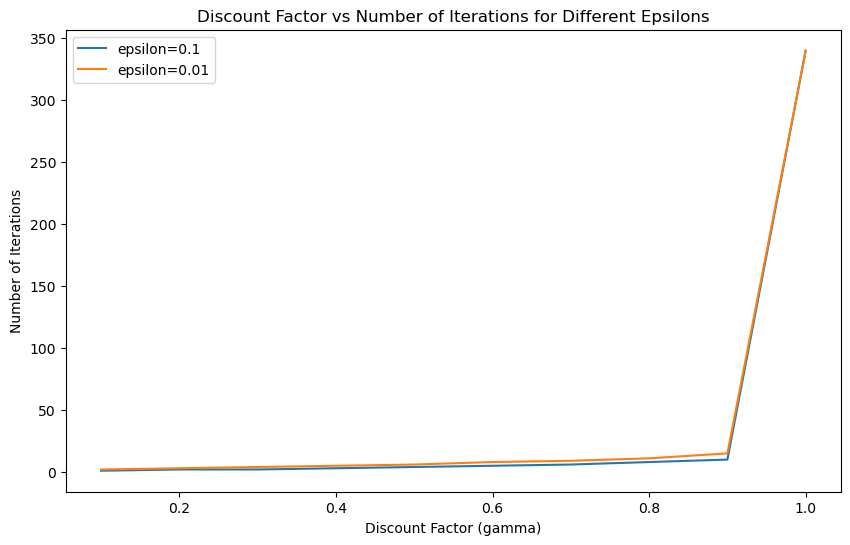

In [9]:
import matplotlib.pyplot as plt

def plot_discount_factor_vs_iterations(mdp, discount_factors, epsilons):
    results = {epsilon: [] for epsilon in epsilons}
    for epsilon in epsilons:        
        for gamma in discount_factors:
            #print(f"gamma = {gamma}")
            mdp.gamma = gamma            
            U_all, policy_all, iter_count = value_iteration_viz(mdp, epsilon)            
            results[epsilon].append(iter_count)
        

    fig, ax = plt.subplots(figsize=(10, 6))
    for epsilon, iterations in results.items():
        ax.plot(discount_factors, iterations, label=f'epsilon={epsilon}')

    ax.set_xlabel('Discount Factor (gamma)')
    ax.set_ylabel('Number of Iterations')
    ax.set_title('Discount Factor vs Number of Iterations for Different Epsilons')
    ax.legend()
    plt.show()


default_reward = 0
mdp = GridMDP(default_reward = default_reward)
discount_factors = [i/10 for i in range(1, 11)]  # Discount factors from 0.1 to 0.9
epsilons = [0.1,0.01]  # Different epsilon values   #, 0.01, 0.0001,0.00001, 0.000001
plot_discount_factor_vs_iterations(mdp, discount_factors, epsilons)

{(1, 1): 'U', (2, 1): 'L', (3, 1): 'U', (4, 1): 'L', (1, 2): 'U', (3, 2): 'U', (1, 3): 'R', (2, 3): 'R', (3, 3): 'R'}


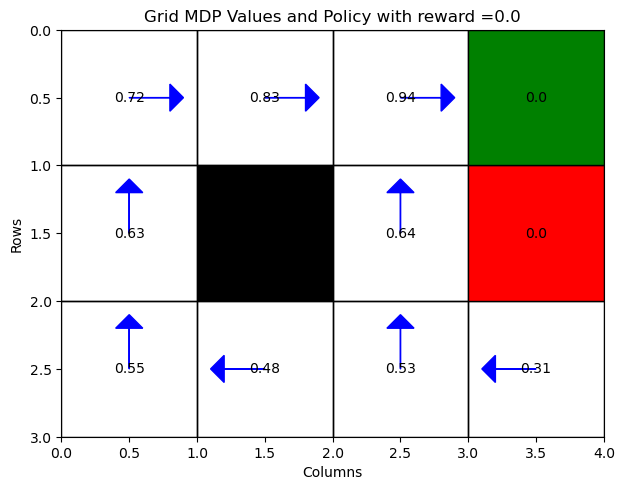

In [10]:
# Another example of value iteration
mdp = GridMDP(gamma = 0.9,default_reward=0.0)
# Perform value iteration to find the optimal value function and policy
all_U, all_policy, iter_count = value_iteration_viz(mdp)
optimal_policy = all_policy[-1]
optimal_utilities = all_U[-1]
#print(all_U)
print(optimal_policy)
plot_policy_with_utilities(mdp, optimal_utilities, optimal_policy)

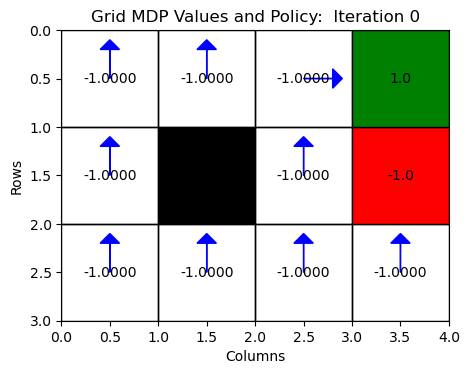

In [15]:
# Create the animation of the value iteration process
ani = animation_policy_with_utilities(mdp, all_U, all_policy, pause_time=1)


# Deterministic MDP 

Each action costs 1 unit, i.e., reward = -1

Only one terminal state with reward of -1 for transition to terminal state

All actions are deterministic

 - prob_intended=1

 - prob_perpendicular=0

Discount factor of 1

 - gamma = 1
 

{(1, 1): -5, (2, 1): -4, (3, 1): -3, (4, 1): -2, (1, 2): -4, (3, 2): -2, (4, 2): -1, (1, 3): -3, (2, 3): -2, (3, 3): -1, (4, 3): 0}


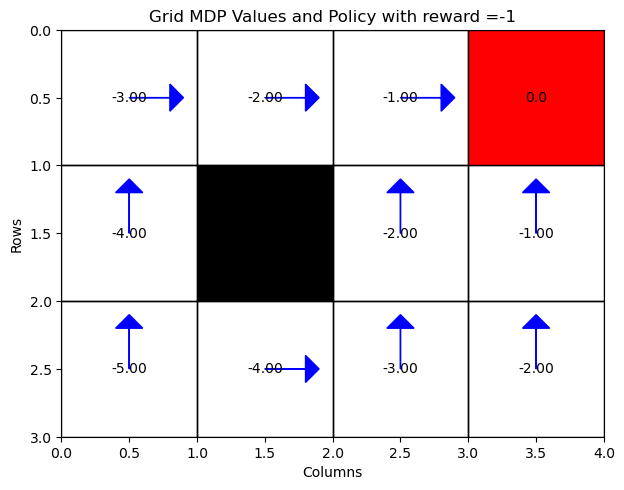

In [12]:
deterministic_mdp = GridMDP(default_reward=-1, terminal_states={(4, 3): -1},prob_intended=1, prob_perpendicular=0, gamma = 1)
# Perform value iteration to find the optimal value function and policy
all_U, all_policy, iter_count = value_iteration_viz(deterministic_mdp)
optimal_policy = all_policy[-1]
optimal_utilities = all_U[-1]
print(optimal_utilities)
plot_policy_with_utilities(deterministic_mdp, optimal_utilities, optimal_policy)

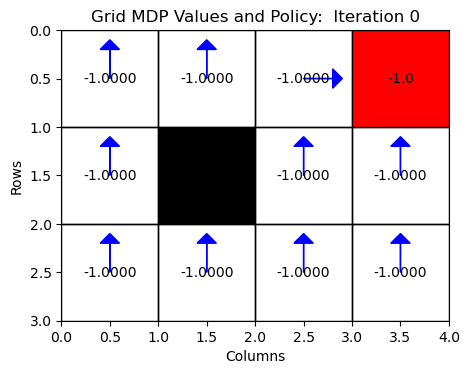

In [16]:
# Create the animation of the value iteration process
ani = animation_policy_with_utilities(deterministic_mdp, all_U, all_policy, pause_time=1)
# Display the animation as a video
#HTML(ani.to_html5_video())